# Scaling up to $n$ emitters

Taking the core circuit for two emitters as a starting point, we can construct the circuit for $n$ emitters by considering two key points: 

### Commutation of Paulis in the interaction Hamiltonian.

The obvious extension of the interaction layer in the Hamiltonian would be a downwards ladder-like stacking. For example, for $n = 4$ 

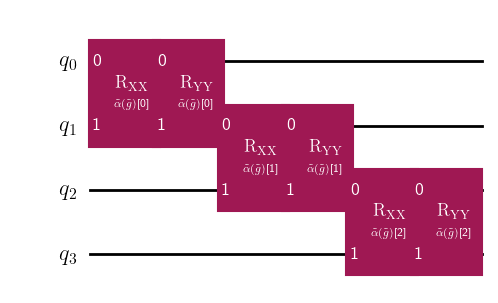

In [2]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import ParameterVector

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

system = QuantumRegister(4, 'q')
qc = QuantumCircuit(system)
tilde_alpha = ParameterVector('$\\tilde{\\alpha} (\\tilde{g})$', 4-1)


for i in range(0,3):

    qc.rxx(tilde_alpha[i], system[i], system[i+1])
    qc.ryy(tilde_alpha[i], system[i], system[i+1])

a = qc.draw('mpl')
a.savefig('figures/ladder_like_stacking.png')
a

However, if we consider the expression for the interaction Hamiltonian,

$$
\begin{align}
H_I = H_I^{(01)} + H_I^{(12)} + H_I^{(23)} = \tilde{g}_{01} (\sigma_0^{\dag} \sigma_1^{\dag} + \sigma_0 \sigma_1^{\dag}) + \tilde{g}_{12} (\sigma_1^{\dag} \sigma_2^{\dag} + \sigma_1 \sigma_2^{\dag}) + \tilde{g}_{23} (\sigma_2^{\dag} \sigma_3^{\dag} + \sigma_2 \sigma_3^{\dag}) 
\end{align}

We see that even though $H_I^{(01)}$ does not commute with $H^{(12)}$, it does with $H_I^{(23)}$, suggesting that we can divide $U_{I} (t) = e^{-iH_It}$ into two layers, each one containing commuting terms:

$$
\begin{align}
U_I(t) \approx U_1 (t) U_2(t) = \left( e^{-it(H_I^{(01)} + H_I^{(23)})} \right) e^{-itH_I^{(12)}}
\end{align}

Notice how this is still approximate since the first layer does not commute with the second but now the exponential in each layer $U_i$ is exactly separable, so we have no Trotterization error inside a layer. Additionally, this separation allows us to perform operations in parallel instead of starwise

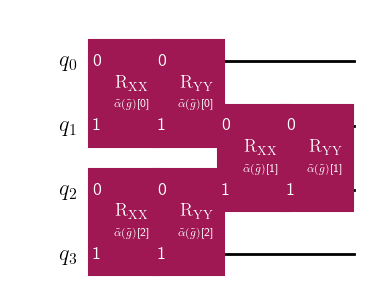

In [4]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

system = QuantumRegister(4, 'q')
qc = QuantumCircuit(system)
tilde_alpha = ParameterVector('$\\tilde{\\alpha} (\\tilde{g})$', 4-1)


for i in range(0,3,2):

    qc.rxx(tilde_alpha[i], system[i], system[i+1])
    qc.ryy(tilde_alpha[i], system[i], system[i+1])

for i in range(1,3,2):

    qc.rxx(tilde_alpha[i], system[i], system[i+1])
    qc.ryy(tilde_alpha[i], system[i], system[i+1])

a = qc.draw('mpl')
a.savefig('figures/layering_of_h_int')
a

### Partial diagonalization. Approximate basis change.

Apart from layering $H_{int}$, we would like to layer the basis change since computing the exact basis change matrix for large $n$ is classically intractable. This would mean assuming that the basis change operator $P'$ can be factorized using just tensor products of $P$ with the identity. For example, for $n=3$,

$$
\begin{align}
P' \approx P_{01} \cdot P_{12} \equiv (P \otimes \mathbf{1}_2) \cdot (\mathbf{1}_0 \otimes P)
\end{align}

Assumming __identical emitters__ just for simplicity, $P = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & -1/\sqrt{2} & 1/\sqrt{2} & 0 \\ 0 & 1/\sqrt{2} & 1/\sqrt{2} & 0 \\ 0 & 0 & 0 & 1  \end{pmatrix} $ and we can construct the $P'$ and obtain the approximately diagonal form of $H$ as a way to check the validity of this approximation.

$$
\begin{align}
H' \equiv P'^{\dag} H P' = \begin{pmatrix} 
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & - \tilde{g} + \tilde{\omega} & 0 & - \frac{\tilde{g}}{2} & 0 & \frac{\tilde{g}}{2} & 0 & 0\\
0 & 0 & \frac{\tilde{g}}{2} + \frac{3 \tilde{\omega}}{2} & 0 & - \frac{\tilde{g}}{2} + \frac{\tilde{\omega}}{2} & - \frac{\sqrt{2} \tilde{g}}{2} & \frac{\tilde{g}}{2} & 0\\
0 & - \frac{\tilde{g}}{2} & 0 & - \frac{\tilde{g}}{2} + \frac{3 \tilde{\omega}}{2} & - \frac{\sqrt{2} \tilde{g}}{2} & - \frac{\tilde{g}}{2} + \frac{\tilde{\omega}}{2} & 0 & 0\\
0 & 0 & - \frac{\tilde{g}}{2} + \frac{\tilde{\omega}}{2} & - \frac{\sqrt{2} \tilde{g}}{2} & \frac{\tilde{g}}{2} + \frac{3 \tilde{\omega}}{2} & 0 & \frac{\tilde{g}}{2} & 0\\
0 & \frac{\tilde{g}}{2} & - \frac{\sqrt{2} \tilde{g}}{2} & - \frac{\tilde{g}}{2} + \frac{\tilde{\omega}}{2} & 0 & - \frac{\tilde{g}}{2} + \frac{3 \tilde{\omega}}{2} & 0 & 0\\
0 & 0 & \frac{\tilde{g}}{2} & 0 & \frac{\tilde{g}}{2} & 0 & \tilde{g} + 2 \tilde{\omega} & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 3 \tilde{\omega}
\end{pmatrix}
\end{align}

The resulting matrix is __strongly diagonally dominant__ (see [1](#references)) for our particular values of $\tilde{\omega}$ and $\tilde{g}$ since, for every $i$, $|h'_{ii}| > \sum_{j \neq i} |h'_{ij}|$. For example, for $\omega = 1.2$, $\omega_c = 1.1$, $\kappa = 0.2$, $g = 0.01$, $\gamma = 0.8 \cdot 10^{-6}$.

$$
H' = \begin{pmatrix}0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 1.2 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 1.801 & 0 & 0.6 & 0 & 0 & 0\\0 & 0 & 0 & 1.8 & 0 & 0.6 & 0 & 0\\0 & 0 & 0.6 & 0 & 1.801 & 0 & 0 & 0\\0 & 0 & 0 & 0.6 & 0 & 1.8 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 2.402 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 3.602\end{pmatrix}

NOTE TO SELF: ~~Finally, this partial diagonalization is expected to work best, the smaller $\left| -\frac{\tilde{g}}{2} + \frac{\tilde{\omega}}{2} \right|$ is. For a given $\tilde{g}$, increasing the effective frequency worsens the basis change.~~ The Frobenius norm is almost the same for increasing $\tilde{\omega}$ since the diagonal elements are changing too so it is not really a good measure of distance in this sense

A more general discussion of the error from partial diagonalization for non-identical emitters can be found in upcoming notebooks.

Taking these two things into account, the generalization is straightforward and the function creating the circuit can be found in `generalized_original_circuit.py` and the one that solves it is `generalized_estimator_solver.py`, both of which can be found in the folder `main_functions`. For $n=6$, the parametric circuit would be the following:

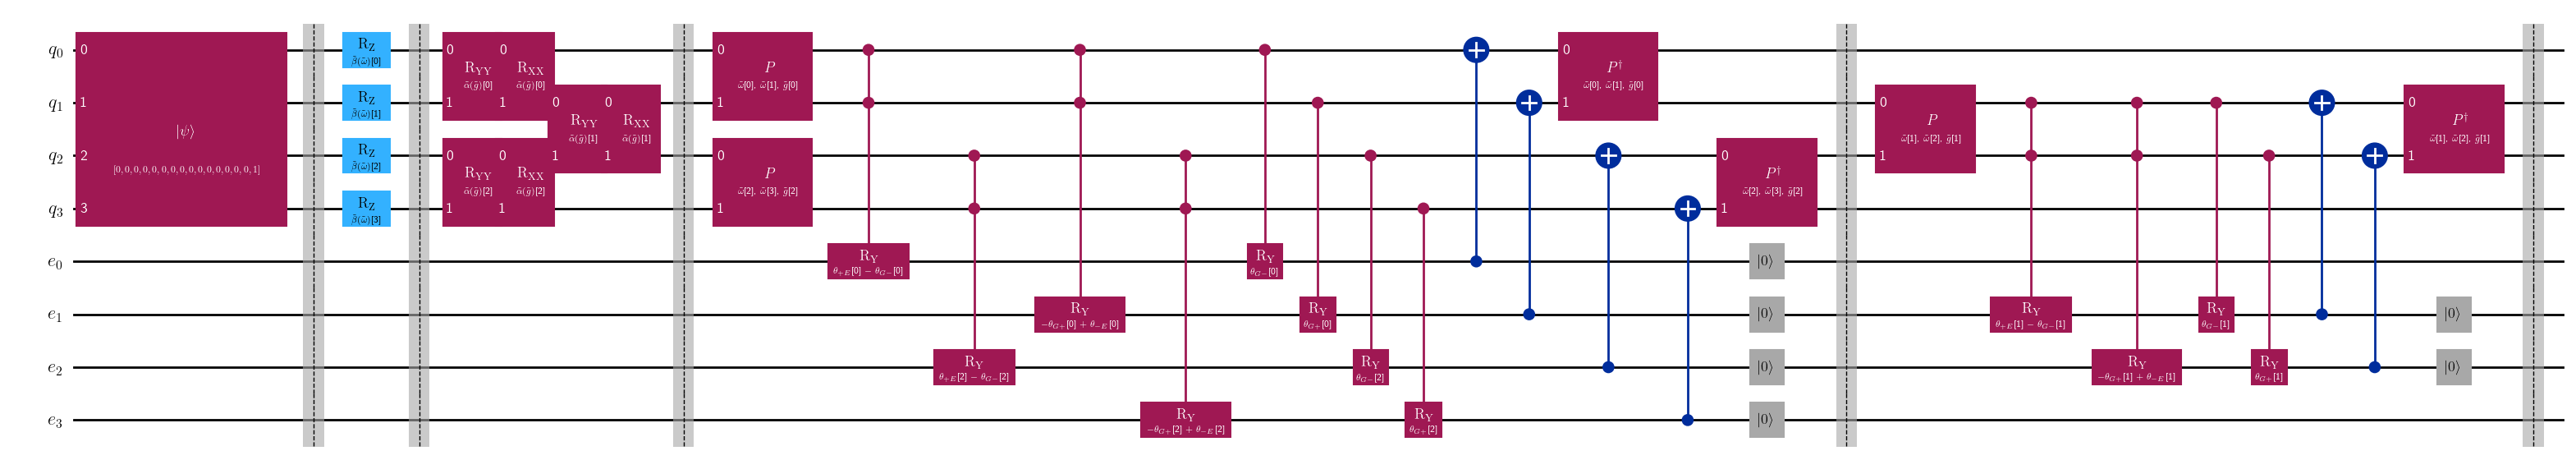

In [1]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter, ControlledGate, Gate, ParameterVector
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RYGate
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

n = 4
initial_state = [0]*(2**n)
initial_state[-1] = 1

system = QuantumRegister(n, name = 'q')
environment = QuantumRegister(n, name = 'e')

omega_eff = ParameterVector('$\\tilde{\\omega}$', n)
g_eff = ParameterVector('$\\tilde{g}$', n-1)

tilde_alpha = ParameterVector('$\\tilde{\\alpha} (\\tilde{g})$', n-1)
tilde_beta = ParameterVector('$\\tilde{\\beta} (\\tilde{\\omega})$', n)

theta_g_plus = ParameterVector(r'$\theta_{G+}$', n-1)
theta_g_minus = ParameterVector(r'$\theta_{G−}$', n-1)
theta_minus_e = ParameterVector(r'$\theta_{−E}$', n-1)
theta_plus_e = ParameterVector(r'$\theta_{+E}$', n-1)

# diff_plus = Parameter(r'$\theta_{−E} - \theta_{G+}$')
# diff_minus = Parameter(r'$\theta_{+E} - \theta_{G−}$')

# Initialization

init = QuantumCircuit(system, environment)
initial_statevector = Statevector(initial_state) 
init.initialize(params = initial_statevector, qubits = system, normalize = True)

init.barrier()

# Free evolution

u_0 = QuantumCircuit(system, environment)

for i in range(n):

    u_0.rz(tilde_beta[i], system[i])

u_0.barrier()

# Interaction layer

u1 = QuantumCircuit(system, environment)

for j in range(0, n-1, 2):

    u1.ryy(tilde_alpha[j], qubit1 = system[j], qubit2 = system[j+1])
    u1.rxx(tilde_alpha[j], qubit1 = system[j], qubit2 = system[j+1])

if n > 2:

    u2 = QuantumCircuit(system, environment)

    for k in range(1, n-1, 2):

        u2.ryy(tilde_alpha[k], qubit1 = system[k], qubit2 = system[k+1])
        u2.rxx(tilde_alpha[k], qubit1 = system[k], qubit2 = system[k+1])

    u_int = u1.compose(u2)

else:

    u_int = u1

u_int.barrier()

# Decay

u_decay = QuantumCircuit(system, environment)

u_decay_first_layer = QuantumCircuit(system, environment)

#ccry_plus = ControlledGate(name = 'ryplus', num_qubits = 3, params = [theta_plus[j] - theta_minus[j]], num_ctrl_qubits= 2, base_gate = RYGate(theta_plus - theta_minus))

#ccry_minus = ControlledGate(name = 'ryminus', num_qubits = 3, params = [theta_minus[j] - theta_plus[j]], num_ctrl_qubits= 2, base_gate = RYGate(theta_minus - theta_plus))

for j in range(0, n-1, 2):
        
        P_gate = Gate(name = 'P', params = [omega_eff[j], omega_eff[j+1], g_eff[j]], num_qubits = 2, label = '$P$')
        
        P_dag_gate = Gate(name = 'Pdag', params = [omega_eff[j], omega_eff[j+1], g_eff[j]], num_qubits = 2, label = '$P^{\\dag}$')

        u_decay_first_layer.append(P_gate, [system[j], system[j+1]])

        diff_plus = theta_minus_e[j] - theta_g_plus[j]

        diff_minus = theta_plus_e[j] - theta_g_minus[j]

        ccry_plus = ControlledGate(name = 'ryplus', num_qubits = 3, params = [diff_plus], num_ctrl_qubits= 2, base_gate = RYGate(diff_plus))

        ccry_minus = ControlledGate(name = 'ryminus', num_qubits = 3, params = [diff_minus], num_ctrl_qubits= 2, base_gate = RYGate(diff_minus))

        u_decay_first_layer.append(ccry_minus, [system[j], system[j+1], environment[j]])

        u_decay_first_layer.append(ccry_plus, [system[j], system[j+1], environment[j+1]])

        u_decay_first_layer.cry(theta_g_minus[j], system[j], environment[j])

        u_decay_first_layer.cry(theta_g_plus[j], system[j+1], environment[j+1])

        u_decay_first_layer.cx(environment[j], system[j])

        u_decay_first_layer.cx(environment[j+1], system[j+1])

        u_decay_first_layer.append(P_dag_gate, [system[j], system[j+1]])

        u_decay_first_layer.reset([environment[j], environment[j+1]])
    
    # And onto the second layer
u_decay_first_layer.barrier()

if n > 2:

    u_decay_second_layer = QuantumCircuit(system, environment)

    for j in range(1, n-1, 2):
        
        P_gate = Gate(name = 'P', params = [omega_eff[j], omega_eff[j+1], g_eff[j]], num_qubits = 2, label = '$P$')
        
        P_dag_gate = Gate(name = 'Pdag', params = [omega_eff[j], omega_eff[j+1], g_eff[j]], num_qubits = 2, label = '$P^{\\dag}$')

        u_decay_second_layer.append(P_gate, [system[j], system[j+1]])

        diff_plus = theta_minus_e[j] - theta_g_plus[j]

        diff_minus = theta_plus_e[j] - theta_g_minus[j]

        ccry_plus = ControlledGate(name = 'ryplus', num_qubits = 3, params = [diff_plus], num_ctrl_qubits= 2, base_gate = RYGate(diff_plus))

        ccry_minus = ControlledGate(name = 'ryminus', num_qubits = 3, params = [diff_minus], num_ctrl_qubits= 2, base_gate = RYGate(diff_minus))

        u_decay_second_layer.append(ccry_minus, [system[j], system[j+1], environment[j]])

        u_decay_second_layer.append(ccry_plus, [system[j], system[j+1], environment[j+1]])

        u_decay_second_layer.cry(theta_g_minus[j], system[j], environment[j])

        u_decay_second_layer.cry(theta_g_plus[j], system[j+1], environment[j+1])

        u_decay_second_layer.cx(environment[j], system[j])

        u_decay_second_layer.cx(environment[j+1], system[j+1])

        u_decay_second_layer.append(P_dag_gate, [system[j], system[j+1]])

        u_decay_second_layer.reset([environment[j], environment[j+1]])

    u_decay = u_decay_first_layer.compose(u_decay_second_layer)

else:

    u_decay = u_decay_first_layer

u_decay.barrier()

u = init.compose(u_0).compose(u_int).compose(u_decay)

a = u.draw('mpl', fold = 70)
a.savefig('figures/generalized_4_emitters_generalization', transparent=True, bbox_inches='tight')
a

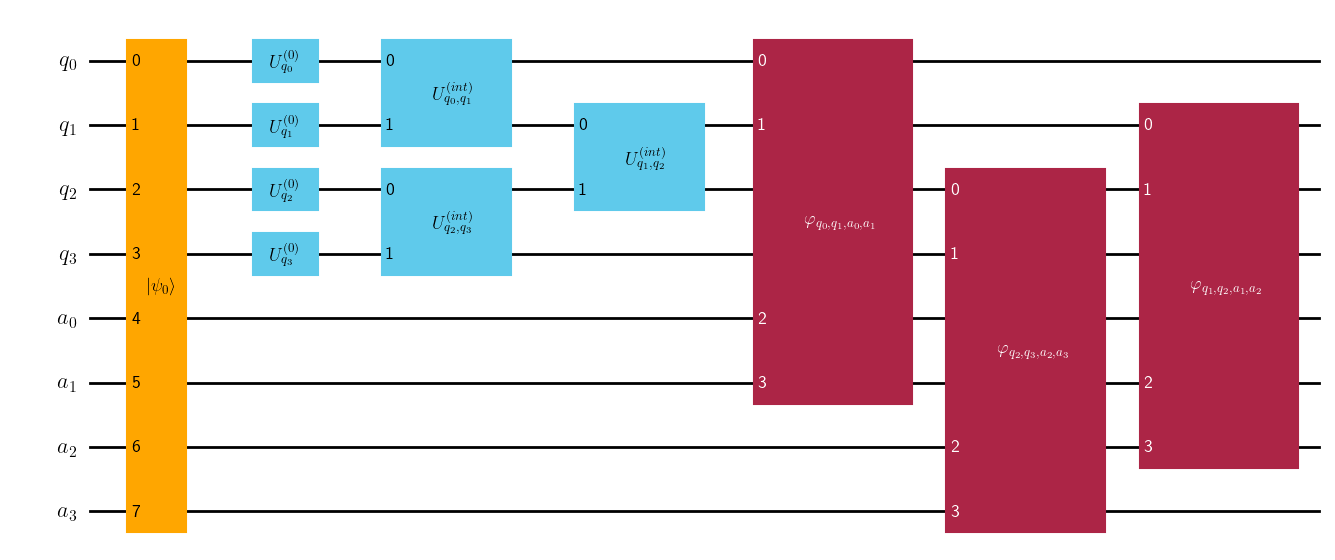

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import UnitaryGate, Initialize
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RYGate
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

style = { 'displaycolor' : {} }
init_color = ("#FFA600", "#000000")
u_color = ("#5FCAEB", "#000000")
diss_color = ("#AC2546", "#FFFFFF")

n = 4
initial_state = [0]*(2**n)
initial_state[-1] = 1

system = QuantumRegister(n, name = 'q')
environment = QuantumRegister(n, name = 'a')

qc = QuantumCircuit(system,environment)

label = r"$\left|\psi_{0} \right>$"
init = UnitaryGate(np.eye(2**(2*n)), label = label)
qc.append(init, qargs = [system[0], system[1], system[2], system[3], environment[0], environment[1], environment[2], environment[3]])
style['displaycolor'][label] = init_color


for i in range(n):
    label = f"$U^{{(0)}}_{{q_{(i)}}}$"
    u_H_0 = UnitaryGate(np.eye(2), label = label)
    qc.append(u_H_0, qargs = [system[i]])
    style['displaycolor'][label] = u_color

for i in range(0, n-1, 2):
    label = f"$U^{{(int)}}_{{q_{(i)}, q_{(i+1)}}}$"
    u_H_int = UnitaryGate(np.eye(2**2), label = label)
    qc.append(u_H_int, qargs = [system[i], system[i+1]])
    style['displaycolor'][label] = u_color

for i in range(1, n-1, 2):
    label = f"$U^{{(int)}}_{{q_{(i)}, q_{(i+1)}}}$"
    u_H_int = UnitaryGate(np.eye(2**2), label = label)
    qc.append(u_H_int, qargs = [system[i], system[i+1]])
    style['displaycolor'][label] = u_color

for i in range(0, n-1, 2):
    label = f"$\\varphi_{{q_{(i)}, q_{(i+1)}, a_{(i)}, a_{(i+1)}}}$"
    varphi = UnitaryGate(np.eye(2**(2*2)), label = label)
    qc.append(varphi, qargs = [system[i], system[i+1], environment[i], environment[i+1]])
    style['displaycolor'][label] = diss_color

for i in range(1, n-1, 2):
    label = f"$\\varphi_{{q_{(i)}, q_{(i+1)}, a_{(i)}, a_{(i+1)}}}$"
    varphi = UnitaryGate(np.eye(2**(2*2)), label = label)
    qc.append(varphi, qargs = [system[i], system[i+1], environment[i], environment[i+1]])
    style['displaycolor'][label] = diss_color


#qc.draw('mpl', wire_order=[0, 4, 1, 5, 2, 6, 3, 7])
# qc.draw(output = 'mpl', style = style, wire_order=[0, 1, 4, 5, 2, 3, 6, 7])
a = qc.draw(output = 'mpl', style = style, wire_order=[0, 1, 2, 3, 4, 5, 6, 7])
a.savefig('figures/schematic_generalization_circuit', transparent=True, bbox_inches='tight')
a

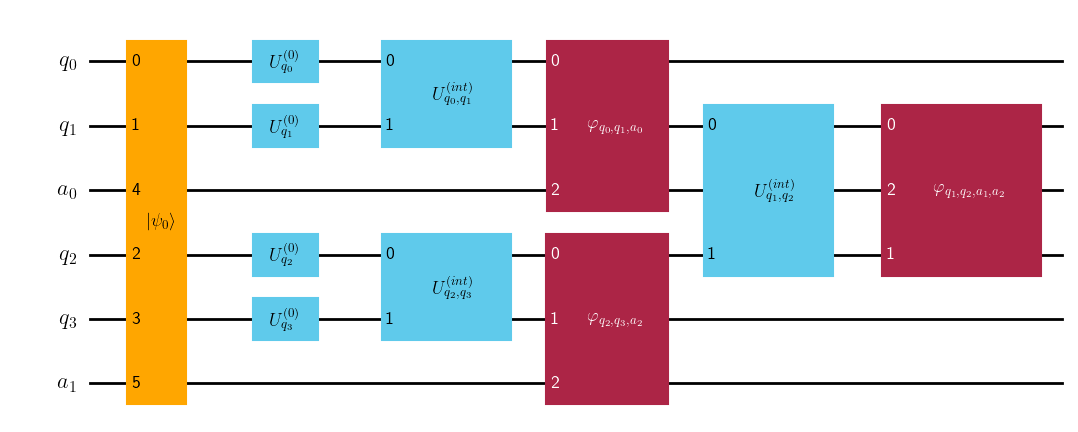

In [6]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import UnitaryGate, Initialize
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RYGate
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

style = { 'displaycolor' : {} }
init_color = ("#FFA600", "#000000")
u_color = ("#5FCAEB", "#000000")
diss_color = ("#AC2546", "#FFFFFF")

n = 4
initial_state = [0]*(2**n)
initial_state[-1] = 1

system = QuantumRegister(n, name = 'q')
environment = QuantumRegister(math.trunc(n/2), name = 'a')

qc = QuantumCircuit(system,environment)

label = r"$\left|\psi_{0} \right>$"
init = UnitaryGate(np.eye(2**(n + math.trunc(n/2))), label = label)
qc.append(init, qargs = [system[0], system[1], system[2], system[3], environment[0], environment[1]])
style['displaycolor'][label] = init_color


for i in range(n):
    label = f"$U^{{(0)}}_{{q_{(i)}}}$"
    u_H_0 = UnitaryGate(np.eye(2), label = label)
    qc.append(u_H_0, qargs = [system[i]])
    style['displaycolor'][label] = u_color

for i in range(0, n-1, 2):
    label = f"$U^{{(int)}}_{{q_{(i)}, q_{(i+1)}}}$"
    u_H_int = UnitaryGate(np.eye(2**2), label = label)
    qc.append(u_H_int, qargs = [system[i], system[i+1]])
    style['displaycolor'][label] = u_color

counter = 0
for i in range(0, n-1, 2):
    label = f"$\\varphi_{{q_{(i)}, q_{(i+1)}, a_{(i)}}}$"
    varphi = UnitaryGate(np.eye(2**(3)), label = label)
    qc.append(varphi, qargs = [system[i], system[i+1], environment[counter]])
    style['displaycolor'][label] = diss_color
    counter += 1

for i in range(1, n-1, 2):
    label = f"$U^{{(int)}}_{{q_{(i)}, q_{(i+1)}}}$"
    u_H_int = UnitaryGate(np.eye(2**2), label = label)
    qc.append(u_H_int, qargs = [system[i], system[i+1]])
    style['displaycolor'][label] = u_color

counter = 0
for i in range(1, n-1, 2):
    label = f"$\\varphi_{{q_{(i)}, q_{(i+1)}, a_{(i)}, a_{(i+1)}}}$"
    varphi = UnitaryGate(np.eye(2**(3)), label = label)
    qc.append(varphi, qargs = [system[i], system[i+1], environment[counter]])
    style['displaycolor'][label] = diss_color
    counter += 1


#qc.draw('mpl', wire_order=[0, 4, 1, 5, 2, 6, 3, 7])
# qc.draw(output = 'mpl', style = style, wire_order=[0, 1, 4, 5, 2, 3, 6, 7])
a = qc.draw(output = 'mpl', style = style, wire_order=[0, 1, 4, 2, 3, 5])
a.savefig('figures/reduced_schematic_generalization_circuit', transparent=True, bbox_inches='tight')
a

For the moment, the only thing left is to check that this circuit indeed yields accurate results for the population dynamics of the emitters.

In [12]:
from main_functions.ME_solver import solve_master_equation
from main_functions.generalized_estimator_solver import estimator_solver
from main_functions.generalized_original_circuit import get_circuit
from qiskit_aer import AerSimulator
import numpy as np

omega_c = 1.1
kappa = [0.2]

t = np.linspace(0, 250, 250)

r = 10
backend = AerSimulator()
optimization_level = 0
options = {'resilience_level' : 1,
           'default_shots' : 10**4}
           #'optimization_level' : 1}

n_molecules = [6]

qc_populations = {}
qutip_populations = {}

for i in n_molecules:

    omega_m = [ np.random.uniform(1, 1.8) for i in range(i)]
    omega_c = np.random.uniform(1, 1.8)
    gamma = [ np.random.uniform(0.1*(10**-6), 1*(10**-6)) for i in range(i)]
    kappa = [np.random.uniform(0.1,0.8)]
    g = [ np.random.uniform(0.01, 0.09) for i in range(2*(i-1)) ]
    initial_state = [0]*(2**i)
    initial_state[-1] = 1

    evs_markov = solve_master_equation(i, omega_m, omega_c, gamma, kappa, g, t, initial_state, 'markovian')
    qc = get_circuit(i, omega_m, omega_c, g, gamma, kappa, initial_state, r)
    evs_qc = estimator_solver(qc, i, t, backend, optimization_level, options)

    qc_populations['n = %s' %i] = evs_qc
    qutip_populations['n = %s' %i] = evs_markov

    print('n = %s finished!' %i)

np.savez('data/six_non_identical_emitters_qc_populations', qc_populations)
np.savez('data/six_non_identical_emitters_markovian_populations', qutip_populations)

c:\Users\Benjamin\AppData\Local\Programs\Python\Python312\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:186: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


n = 6 finished!


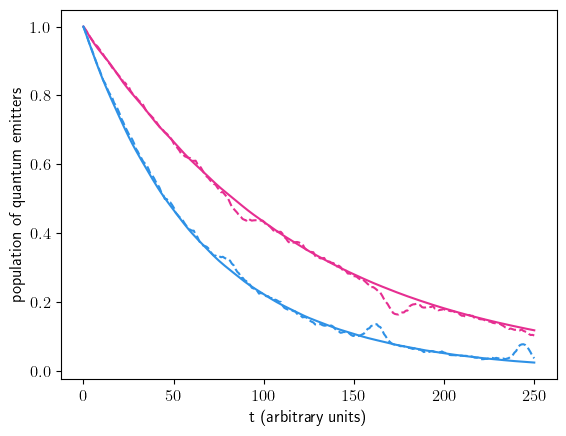

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import colorsys
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600
plt.rcParams.update({'font.size': 12})
#plt.rcParams.update({'font.size': 22})
from utils.generate_complementary_colors import generate_complementary_colors

qc_data = np.load('data/six_non_identical_emitters_qc_populations.npz', allow_pickle = True)
qutip_data = np.load('data/six_non_identical_emitters_markovian_populations.npz', allow_pickle = True)

qc_pops = qc_data['arr_0'].item()
qutip_pops = qutip_data['arr_0'].item()

t = np.linspace(0, 250, 250)

plot_qubits = ['0','4']

for key in qc_pops:

    for qubit in plot_qubits:

        colors = generate_complementary_colors(len(qc_pops[key].keys()), palette_type = 'default', start_color = 'deeppink')

        plt.plot(t, qutip_pops[key][qubit], color = colors[int(qubit)])
        plt.plot(t, qc_pops[key][qubit], color = colors[int(qubit)], linestyle = 'dashed')
        plt.plot(np.NaN, np.NaN, linestyle = 'None', marker = '.', color =  colors[int(qubit)], label = '$q_{%i}$' %int(qubit))

plt.plot(np.NaN, np.NaN, linestyle = 'dashed', color = 'black', label = 'Quantum simulation')
plt.plot(np.NaN, np.NaN, linestyle = 'solid', color = 'black', label = 'Exact solution')
plt.xlabel('t (arbitrary units)')
plt.ylabel('population of quantum emitters')
#plt.yscale('log')
#plt.title('six emitters and five cavities')
#plt.legend(frameon=False, fontsize = 'small')
#plt.xlim([0,200])
#plt.savefig('figures/generalized_original_circuit_6_non_identical_emitters_population_dynamics_BIG', bbox_inches='tight')
plt.savefig('figures/generalized_original_circuit_6_non_identical_emitters_population_dynamics.svg', bbox_inches='tight', format = 'svg')
plt.show()


## References <a id='references'></a>

[1] https://en.wikipedia.org/wiki/Diagonally_dominant_matrix